<img src="NotebookAddons/blackboard-banner.png" width="100%" />
<font face="Calibri">
<br>
<font size="5"> <b>Change Detection in <font color='rgba(200,0,0,0.2)'>Your Own</font> SAR Amplitude Time Series Stack </b> </font>

<br>
<font size="4"> <b> Franz J Meyer; University of Alaska Fairbanks & Josef Kellndorfer, <a href="http://earthbigdata.com/" target="_blank">Earth Big Data, LLC</a> </b> <br>
<img style="padding: 7px" src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right"/>
</font>

<font size="3"> This notebook introduces you to the methods of change detection in deep multi-temporal SAR image data stacks. 
<br><br>
<b>In this chapter we introduce the following data analysis concepts:</b>

- How to use your own HyP3-generated data stack in a change detection effort
- The concepts of time series slicing by month, year, and date.
- The concepts and workflow of Cumulative Sum-based change point detection.
- The identification of change dates for each identified change point.
</font>
</font>

<hr>
<font face="Calibri" size="5" color="darkred"> <b>Important Note about JupyterHub</b> </font>
<br><br>
<font face="Calibri" size="3"> <b>Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.</b> </font>


<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3">In this notebook we will use the following scientific libraries:
<ol type="1">
    <li> <b><a href="https://pandas.pydata.org/" target="_blank">Pandas</a></b> is a Python library that provides high-level data structures and a vast variety of tools for analysis. The great feature of this package is the ability to translate rather complex operations with data into one or two commands. Pandas contains many built-in methods for filtering and combining data, as well as the time-series functionality. </li>
    <li> <b><a href="https://www.gdal.org/" target="_blank">GDAL</a></b> is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.</li>
    <li> <b><a href="http://www.numpy.org/" target="_blank">NumPy</a></b> is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects. </li>
    <li> <b><a href="https://matplotlib.org/index.html" target="_blank">Matplotlib</a></b> is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. Moreover, many popular plotting libraries are designed to work in conjunction with matplotlib. </li>

</font>
<br>
<font face="Calibri" size="3"><b>Our first step is to import them:</b> </font>

In [82]:
%%capture
import os
import glob
import json # for loads

import pandas as pd
from osgeo import gdal
import numpy as np
import matplotlib.pylab as plt

from IPython.display import HTML

from asf_notebook import new_directory
from asf_notebook import path_exists
from asf_notebook import gui_date_picker
from asf_notebook import jupytertheme_matplotlib_format

<font face="Calibri" size="3"><b>Setup matplotlib plotting</b> inside the notebook:</font>

In [83]:
%%capture
jupytertheme_matplotlib_format()
%matplotlib inline 

<hr>
<font face="Calibri">

<font size="5"> <b> 1. Load Your Prepared Data Stack Into the Notebook </b> </font> 

<font size="3"> This notebook assumes that you've prepared your own data stack of <b>RTC image products</b> over your personal area of interest. This can be done using the <b>Prepare_Data_Stack_Hyp3</b> and <b>Subset_Data_Stack notebooks</b>.
    
This notebook expects <a href="https://media.asf.alaska.edu/uploads/RTC/rtc_atbd_v1.2_final.pdf" target="_blank">Radiometric Terrain Corrected</a> (RTC) image products as input, so be sure to select an RTC process when creating the subscription for your input data within HyP3. Prefer a **unique orbit geometry** (ascending or descending) to keep geometric differences between images low. 

<b>Begin by writing a function to retrieve and the absolute paths to each of our tiffs:</b>
</font> 
</font>

In [84]:
def get_tiff_paths(paths):
    tiff_paths = !ls $paths | sort -t_ -k5,5
    return tiff_paths

<font face="Calibri" size="3"><b>Enter the path to the directory holding your tiffs:</b> </font>

In [85]:
# /Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer
while True:
    print("Enter the absolute path to the directory holding your tiffs.")
    tiff_dir = input()
    wildcard_path = f"{tiff_dir}/*.tif*"
    if os.path.exists(tiff_dir):
        tiff_paths = get_tiff_paths(wildcard_path)
        if len(tiff_paths) < 1:
            print(f"{tiff_dir} exists but contains no tifs.")
            print("You will not be able to proceed until tifs are prepared.")
        break
    else:
        print(f"\n{tiff_dir} does not exist.")
        continue

Enter the absolute path to the directory holding your tiffs.
/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer


<font face="Calibri" size="3"><b>Determine the path to the analysis directory containing the tiff directory:</b> </font>

In [86]:
analysis_dir = os.path.dirname(tiff_dir)
print(analysis_dir)

/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data


In [87]:
# Added this line to change the working directory
os.chdir(analysis_dir)

<font face="Calibri" size="3"><b>Create a wildcard path to the tiffs:</b> </font>

In [88]:
wildcard_path = f"{tiff_dir}/*.tif*"
print(wildcard_path)

/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/*.tif*


<font face="Calibri" size="3"><b>Write a function to extract the tiff dates from a wildcard path:</b> </font>

In [89]:
def get_dates(paths):
    dates = []
    pths = glob.glob(paths)
    for p in pths:
        filename = os.path.basename(p).split('_')
        for chunk in filename:
            if len(chunk) == 15 and 'T' in chunk:
                date = chunk.split('T')[0]
                dates.append(date)
                break
            elif len(chunk) == 8:
                try:
                    int(chunk)
                    dates.append(chunk)
                    break
                except ValueError:
                    continue              
    dates.sort()
    return dates

<font face="Calibri" size="3"><b>Call get_dates() to collect the product acquisition dates:</b></font>

In [90]:
dates = get_dates(wildcard_path)
print(dates)

['20180619', '20180623', '20180701', '20180705', '20180713', '20180717', '20180725', '20180729', '20180806', '20180810']


In [146]:
tiff_paths

['/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180619_VV.tiff',
 '/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180623_VV.tiff',
 '/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180701_VV.tiff',
 '/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180705_VV.tiff',
 '/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180713_VV.tiff',
 '/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180717_VV.tiff',
 '/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180725_VV.tiff',
 '/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180729_VV.tiff',
 '/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180806_VV.tiff',
 '/Users/biplovbhandari/UAH/Spring_20

In [18]:
for tfile in tiff_paths:
    _, file_w_ext = tfile.split(f'{tiff_dir}/')
    input_f, _ = file_w_ext.split('tiff')
    input_path = f'{tiff_dir}/{file_w_ext}'
#     print(input_path)
    output_f = f'{tiff_dir}/{input_f}_projected.tiff'
#     print(output_f)
    !gdalwarp $input_path $output_f -t_srs EPSG:32722

Processing /Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180705_VV.tiff [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180705_VV.tiff.
...10...20...30...40...50...60...70...80...90...100 - done.
Processing /Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180729_VV.tiff [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180729_VV.tiff.
...10...20...30...40...50...60...70...80...90...100 - done.
Processing /Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180623_VV.tiff [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/20180623_VV.tiff.
...10...20...30...40...50...60...70...80...90...100 - d

<font face="Calibri" size="3"><b>Gather the upper-left and lower-right corner coordinates of the data stack:</b></font>

In [147]:
coords = [[], []]
info = (gdal.Info(tiff_paths[0], options = ['-json']))
info = json.dumps(info)
coords[0] = (json.loads(info))['cornerCoordinates']['upperLeft']
coords[1] = (json.loads(info))['cornerCoordinates']['lowerRight']
print(coords)

[[607860.0, 1724130.0], [768060.0, 1591740.0]]


<font face="Calibri" size="3"><b>Grab the stack's UTM zone.</b> Note that any UTM zone conflicts should already have been handled in the Prepare_Data_Stack_Hyp3 notebook.</font>

In [17]:
# utm = json.loads(info)['coordinateSystem']['wkt'].split('ID')[-1].split(',')[1][0:-2]
utm = '32722'
print(f"UTM Zone: {utm}")

UTM Zone: 32722


<hr>
<font face="Calibri" size="3"> Now we stack up the data by creating a virtual raster table with links to all subset data files: </font>
<br><br>
<font size="3"><b>Create the virtual raster table for the subset GeoTiffs:</b></font>

In [149]:
!gdalbuildvrt -separate raster_stack.vrt $wildcard_path

0...10...20...30...40...50...60...70...80...90...100 - done.


<hr>
<font face="Calibri">

<font size="5"> <b> 3. Now You Can Work With Your Data </b> </font> 

<font size="3"> Now you are ready to perform time series change detection on your data stack.
</font> 
</font>

<br>
<font face="Calibri" size="4"> <b> 3.1 Define Data Directory and Path to VRT </b> </font> 
<br><br>
<font face="Calibri" size="3"><b>Create a variable containing the VRT filename:</b></font>

In [150]:
image_file = "raster_stack.vrt"

<font face="Calibri" size="3"><b>Create an index of timedelta64 data with Pandas:</b></font>

In [151]:
# Get some indices for plotting
time_index = pd.DatetimeIndex(dates)

<font face="Calibri" size="3"><b>Print the bands and dates for all images in the virtual raster table (VRT):</b></font>

In [152]:
j = 1
print(f"Bands and dates for {image_file}")
for i in time_index:
    print("{:4d} {}".format(j, i.date()), end=' ')
    j += 1
    if j%5 == 1: print()

Bands and dates for raster_stack.vrt
   1 2018-06-19    2 2018-06-23    3 2018-07-01    4 2018-07-05    5 2018-07-13 
   6 2018-07-17    7 2018-07-25    8 2018-07-29    9 2018-08-06   10 2018-08-10 


<hr>
<br>
<font face="Calibri" size="4"> <b> 3.2 Open Your Data Stack with gdal </b> </font> 

In [153]:
img = gdal.Open(image_file)

<font face="Calibri" size="3"><b>Print the bands, pixels, and lines:</b></font>

In [154]:
print(f"Number of  bands: {img.RasterCount}")
print(f"Number of pixels: {img.RasterXSize}")
print(f"Number of  lines: {img.RasterYSize}")

Number of  bands: 10
Number of pixels: 5340
Number of  lines: 4413


<hr><hr>
<font face="Calibri" size="4"> <b> 3.3 Create a masked raster stack:</b></font>

In [155]:
raster_stack = img.ReadAsArray()
raster_stack_masked = np.ma.masked_where(raster_stack==0, raster_stack)
del raster_stack

<br>
<hr>
<font face="Calibri" size="5"> <b> 4. Cumulative Sum-based Change Detection Across an Entire Image</b> </font> 

<font face="Calibri" size="3"> Using numpy arrays we can apply the concept of **cumulative sum change detection** analysis effectively on the entire image stack. We take advantage of array slicing and axis-based computing in numpy. **Axis 0 is the time domain** in our raster stacks.
    
<hr>
<font size="4"><b>4.1 Create our time series stack</b></font> 
<br><br>
<font size="3"><b>Calculate the dB scale:</b></font> 

In [156]:
# play with data to understand what is going on here
raster_stack_masked.shape
# time, height, width

(10, 4413, 5340)

In [243]:
db = raster_stack_masked
# db = 10.*np.ma.log10(raster_stack_masked)

<font face="Calibri" size="3">Sometimes it makes sense to <b>extract a reduced time span</b> from the full time series to reduce the number of different change objects in a scene. In the following, we extract a shorter time span:
</font>

In [244]:
date_picker = gui_date_picker(dates)
date_picker

SelectionRangeSlider(description='Dates', index=(0, 52), layout=Layout(width='500px'), options=((' 06/19/2018 …

In [245]:
subset_dates = date_picker.value
subset_dates = pd.DatetimeIndex(subset_dates)
date_index_subset = np.where((time_index>=subset_dates[0]) & (time_index<=subset_dates[1]))
db_subset = np.squeeze(db[date_index_subset, :, :])
time_index_subset = time_index[date_index_subset]

0.0
0.30222365558147435


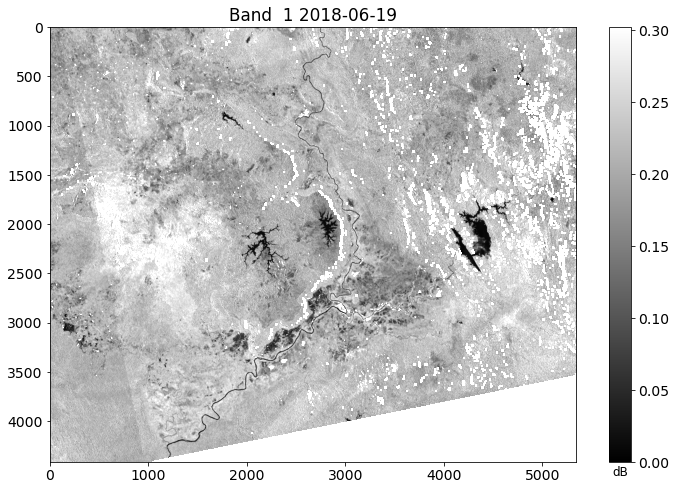

In [246]:
plt.figure(figsize=(12, 8))
band_number = 0
vmin = np.percentile(db_subset[band_number], 5)
print(vmin)
vmax = np.percentile(db_subset[band_number], 95)
print(vmax)
plt.title('Band  {} {}'.format(band_number+1, time_index_subset[band_number].date()))
plt.imshow(db_subset[0], cmap='gray', vmin=vmin, vmax=vmax)
cbar = plt.colorbar()
_ = cbar.ax.set_xlabel('dB', fontsize='12')

<br>
<hr>
<font face="Calibri" size="4"> <b> 4.2 Calculate Mean Across Time Series to Prepare for Calculation of Cummulative Sum $S$:</b> </font> 
<br><br>
<font face="Calibri" size="3"><b>Write a function to convert our plots into GeoTiffs:</b></font> 

In [247]:
def geotiff_from_plot(source_image, out_filename, extent, utm, cmap=None, vmin=None, vmax=None, interpolation=None, dpi=300):
    assert "." not in out_filename, 'Error: Do not include the file extension in out_filename'
    assert type(extent) == list and len(extent) == 2 and len(extent[0]) == 2 and len(
        extent[1]) == 2, 'Error: extent must be a list in the form [[upper_left_x, upper_left_y], [lower_right_x, lower_right_y]]'
    
    plt.figure()
    plt.axis('off')
    plt.imshow(source_image, cmap=cmap, vmin=vmin, vmax=vmax, interpolation=interpolation)
    temp = f"{out_filename}_temp.png"
    plt.savefig(temp, dpi=dpi, transparent='true', bbox_inches='tight', pad_inches=0)

    cmd = f"gdal_translate -of Gtiff -a_ullr {extent[0][0]} {extent[0][1]} {extent[1][0]} {extent[1][1]} -a_srs EPSG:{utm} {temp} {out_filename}.tiff"
    !{cmd}
    try:
        os.remove(temp)
    except FileNotFoundError:
        pass

<font face="Calibri" size="3"><b>Create a directory in which to store our plots and animations:</b></font> 

In [248]:
output_path = f"{tiff_dir}/plots_and_animations"
new_directory(output_path)

/Users/biplovbhandari/UAH/Spring_2021/GEOS_657/Project/Data/subset_tiffs_100km_buffer/plots_and_animations already exists.


<font face="Calibri" size="3"><b>Plot the time-series mean and save as a png (time_series_mean.png):</b></font> 

0.005038584396243095
249.2378173828125


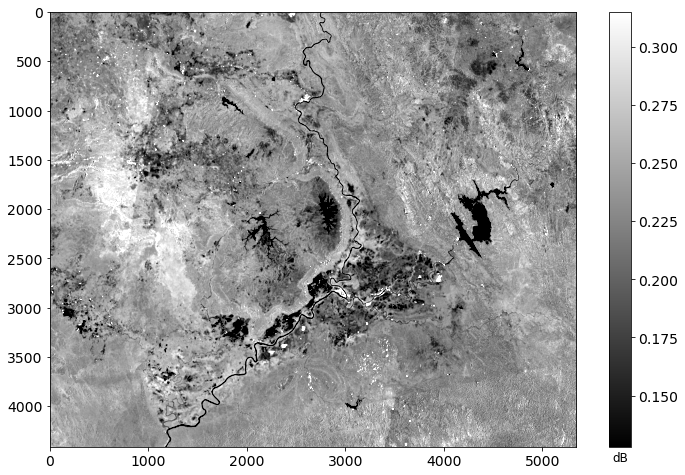

In [249]:
db_mean = np.mean(db_subset, axis=0)
plt.figure(figsize=(12, 8))
vmin = np.nanpercentile(db_mean, 2)
print(db_mean.min());
vmax = np.nanpercentile(db_mean, 98)
print(db_mean.max());
plt.imshow(db_mean, cmap='gray', vmin=vmin, vmax=vmax)
cbar = plt.colorbar()
cbar.ax.set_xlabel('dB', fontsize='12')
plt.savefig(f"{output_path}/time_series_mean.png", dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the time-series mean as a GeoTiff (time_series_mean.tiff):</b></font> 

In [250]:
%%capture
geotiff_from_plot(db_mean, f"{output_path}/time_series_mean", coords, utm, cmap='gray')

<font face="Calibri" size="3"><b>Calculate the residuals and plot residuals[0]. Save it as a png (residuals.png):</b></font> 

In [251]:
time_index_subset

DatetimeIndex(['2018-06-19', '2018-06-23', '2018-07-01', '2018-07-05',
               '2018-07-13', '2018-07-17', '2018-07-25', '2018-07-29',
               '2018-08-06', '2018-08-10'],
              dtype='datetime64[ns]', freq=None)

112.51490173339843


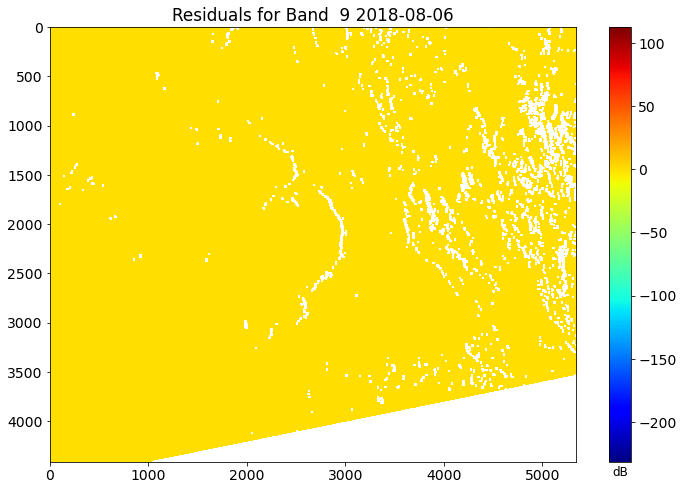

In [252]:
residuals = db_subset - db_mean
band_number = 8
print(residuals[band_number].max())
plt.figure(figsize=(12, 8))
plt.imshow(residuals[band_number], cmap='jet')
plt.title('Residuals for Band  {} {}'.format(band_number+1, time_index_subset[band_number].date()))
cbar = plt.colorbar()
_ = cbar.ax.set_xlabel('dB', fontsize='12')
plt.savefig(f"{output_path}/residuals.png", dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the residuals[0] as a GeoTiff (residuals.tiff):</b></font> 

In [253]:
%%capture
geotiff_from_plot(residuals[0], f"{output_path}/residuals", coords, utm)

<br>
<hr>
<font face="Calibri" size="4"><b> 4.3 Calculate Cummulative Sum $S$ as well as Change Magnitude $S_{diff}$:</b></font> 
<br><br>
<font face="Calibri" size="3"><b>Plot Smin, Smax, and the change magnitude and save a png of the plots (Smin_Smax_Sdiff.png):</b></font> 

(10, 4413, 5340)
(4413, 5340)
(4413, 5340)
722.1508178710938


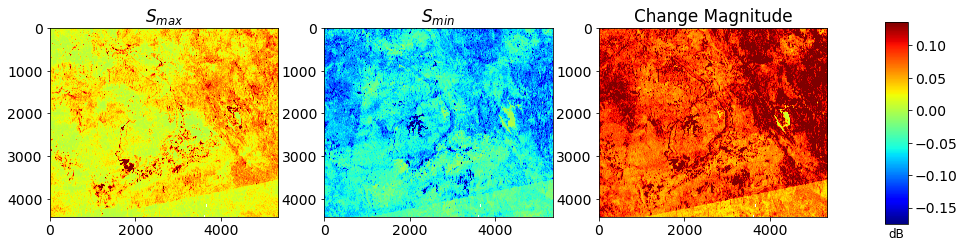

In [254]:
summation = np.cumsum(residuals, axis=0)
print(summation.shape);
summation_max = np.max(summation, axis=0)
print(summation_max.shape);
summation_min = np.min(summation, axis=0)
print(summation_min.shape);
change_mag = summation_max - summation_min
print(change_mag.max())
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
vmin = np.percentile(summation_min.flatten(), 3)
vmax = np.percentile(summation_max.flatten(), 97)
max_plot = ax[0].imshow(summation_max, cmap='jet', vmin=vmin, vmax=vmax)
ax[0].set_title('$S_{max}$')
ax[1].imshow(summation_min, cmap='jet', vmin=vmin, vmax=vmax)
ax[1].set_title('$S_{min}$')
ax[2].imshow(change_mag, cmap='jet', vmin=vmin, vmax=vmax)
ax[2].set_title('Change Magnitude')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(max_plot, cax=cbar_ax)
_ = cbar.ax.set_xlabel('dB', fontsize='12')
plt.savefig(f"{output_path}/Smin_Smax_Sdiff.png", dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save Smax as a GeoTiff (Smax.tiff):</b></font> 

In [255]:
%%capture
geotiff_from_plot(summation_max, f"{output_path}/Smax", coords, utm, vmin=vmin, vmax=vmax)

<font face="Calibri" size="3"><b>Save Smin as a GeoTiff (Smin.tiff):</b></font> 

In [256]:
%%capture
geotiff_from_plot(summation_min, f"{output_path}/Smin", coords, utm, vmin=vmin, vmax=vmax)

<font face="Calibri" size="3"><b>Save the change magnitude as a GeoTiff (Sdiff.tiff):</b></font> 

In [257]:
%%capture
geotiff_from_plot(change_mag, f"{output_path}/Sdiff", coords, utm, vmin=vmin, vmax=vmax)

<br>
<hr>
<font face="Calibri" size="4"> <b> 4.4 Mask $S_{diff}$ With a-priori Threshold To Idenfity Change Candidates:</b> </font>

<font face="Calibri" size="3">To identified change candidate pixels, we can threshold $S_{diff}$ to reduce computation of the bootstrapping. For land cover change, we would not expect more than 5-10% change pixels in a landscape. So, if the test region is reasonably large, setting a threshold for expected change to 10% is appropriate. In our example, we'll start out with a very conservative threshold of 50%.
<br><br>
<b>Plot and tsave the histogram and CDF for the change magnitude (change_mag_histogram_CDF.png):</b></font>

(4413, 5340)
722.1508178710938
0.0
[0.1478908  0.63838616 0.87180832 0.9474207  0.97506661 0.98667331
 0.99211105 0.99492703 0.9964949  0.99746142 0.99811853 0.99859585
 0.99892837 0.99913958 0.99927893 0.99937696 0.99945657 0.99951988
 0.99957089 0.99961511 0.99965012 0.99967931 0.99970673 0.99973159
 0.99975264 0.99977047 0.99978859 0.99980412 0.99981664 0.99982856
 0.99983913 0.99984757 0.99985576 0.99986281 0.99986989 0.99987571
 0.99988267 0.99988789 0.99989344 0.99989824 0.99990244 0.99990732
 0.99991076 0.99991487 0.99991831 0.99992166 0.99992497 0.99992769
 0.99993024 0.99993299 0.99993529 0.99993775 0.99994029 0.99994246
 0.9999442  0.99994589 0.99994819 0.9999498  0.99995175 0.99995336
 0.99995493 0.99995672 0.99995799 0.99995939 0.99996113 0.9999624
 0.99996351 0.99996448 0.99996558 0.99996652 0.99996754 0.99996856
 0.99996915 0.99996996 0.99997055 0.99997127 0.99997199 0.99997276
 0.99997377 0.99997428 0.99997518 0.99997577 0.99997658 0.99997725
 0.99997793 0.99997857 0.999

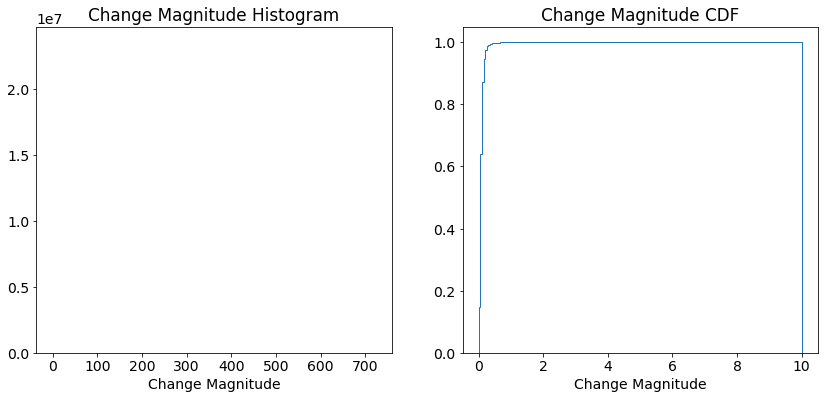

In [259]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(14, 6)) # Initialize figure with a size
ax1 = fig.add_subplot(121)  # 121 determines: 2 rows, 2 plots, first plot
ax2 = fig.add_subplot(122)
print(change_mag.shape)
print(change_mag.max())
print(change_mag.min())
# Second plot: Histogram
# IMPORTANT: To get a histogram, we first need to *flatten* 
# the two-dimensional image into a one-dimensional vector.
histogram = ax1.hist(change_mag.flatten(), bins=500, range=(0, np.max(change_mag)))
# histogram = ax1.hist(change_mag.flatten(), bins=500, range=(0, 1))
ax1.xaxis.set_label_text('Change Magnitude')
ax1.set_title('Change Magnitude Histogram')
plt.grid()
# n, bins, patches = ax2.hist(change_mag.flatten(), bins=200, range=(0, np.max(change_mag)), cumulative='True', density='True', histtype='step', label='Empirical')
n, bins, patches = ax2.hist(change_mag.flatten(), bins=200, range=(0, 10), cumulative='True', density='True', histtype='step', label='Empirical')
print(n);
print(bins);
ax2.xaxis.set_label_text('Change Magnitude')
ax2.set_title('Change Magnitude CDF')
plt.grid()
plt.savefig(f"{output_path}/change_mag_histogram_CDF", dpi=72)

In [230]:
precentile = 0.2
out_indicies = np.where(n>precentile)
threshold_index = np.min(out_indicies)
threshold = bins[threshold_index]
print('At the {}% percentile, the threshold value is {:2.2f}'.format(precentile*100, threshold))

At the 20.0% percentile, the threshold value is 0.89


<font face="Calibri" size="3">Using this threshold, we can <b>visualize our change candidate areas and save them as a png (change_candidate.png):</b></font>

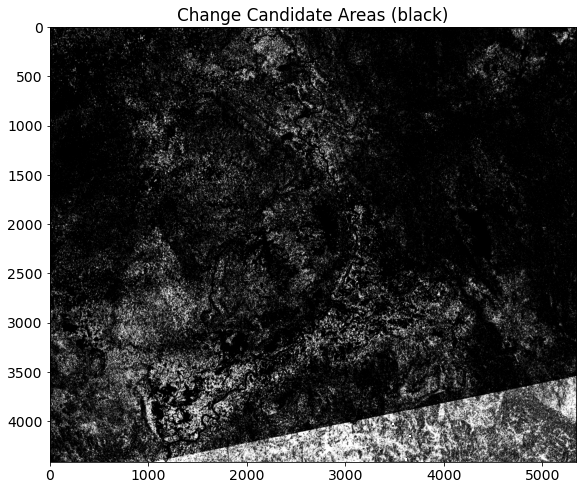

In [232]:
change_mag_mask = change_mag < threshold
plt.figure(figsize=(12, 8))
plt.title('Change Candidate Areas (black)')
_ = plt.imshow(change_mag_mask, cmap='gray')
plt.savefig(f"{output_path}/change_candidate.png", dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the change candidate areas as a GeoTiff (change_canididate.tiff):</b>
</font>

In [46]:
%%capture
geotiff_from_plot(change_mag_mask, f"{output_path}/change_canididate", coords, utm, cmap='gray')

<br>
<hr>
<font face="Calibri" size="4"> <b> 4.5 Bootstrapping to Prepare for Change Point Selection:</b> </font>

<font face="Calibri" size="3">We can now perform bootstrapping over the candidate pixels. The workflow is as follows:
<ul>
    <li>Filter our residuals to the change candidate pixels</li>
    <li>Perform bootstrapping over candidate pixels</li>
</ul>
For efficient computing we permutate the index of the time axis.
</font>

In [233]:
residuals_mask = np.broadcast_to(change_mag_mask , residuals.shape)
residuals_masked = np.ma.array(residuals, mask=residuals_mask)

<font face="Calibri" size="3">On the masked time series stack of residuals, we can re-compute the cumulative sums:
</font>

In [48]:
summation_masked = np.ma.cumsum(residuals_masked, axis=0)

<font face="Calibri" size="3"><b>Plot the masked Smax, Smin, and change magnitude. Save them as a png (masked_Smax_Smin_Sdiff.png):</b>
</font>

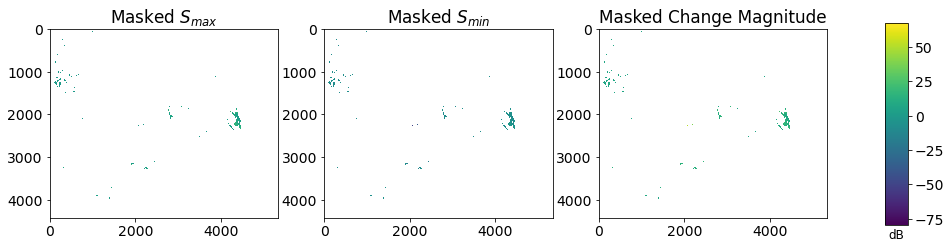

In [49]:
summation_masked_max = np.ma.max(summation_masked, axis=0)
summation_masked_min = np.ma.min(summation_masked, axis=0)
change_mag_masked = summation_masked_max - summation_masked_min
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
vmin = summation_masked_min.min()
vmax = summation_masked_max.max()
masked_sum_max_plot = ax[0].imshow(summation_masked_max, vmin=vmin, vmax=vmax)
ax[0].set_title('Masked $S_{max}$')
ax[1].imshow(summation_masked_min, vmin=vmin, vmax=vmax)
ax[1].set_title('Masked $S_{min}$')
ax[2].imshow(change_mag_masked, vmin=vmin, vmax=vmax)
ax[2].set_title('Masked Change Magnitude')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(masked_sum_max_plot, cax=cbar_ax)
_ = cbar.ax.set_xlabel('dB', fontsize='12')
plt.savefig(f"{output_path}/masked_Smax_Smin_Sdiff.png", dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the masked Smax as a GeoTiff (masked_Smax.tiff):</b>
</font>

In [50]:
%%capture
geotiff_from_plot(summation_masked_max, f"{output_path}/masked_Smax", coords, utm, vmin=vmin, vmax=vmax)

<font face="Calibri" size="3"><b>Save the masked Smin as a GeoTiff (masked_Smin.tiff):</b>
</font>

In [51]:
%%capture
geotiff_from_plot(summation_masked_min, f"{output_path}/masked_Smin", coords, utm, vmin=vmin, vmax=vmax)

<font face="Calibri" size="3"><b>Save the masked change magnitude as a GeoTiff (masked_Sdiff.tiff):</b>
</font>

In [52]:
%%capture
geotiff_from_plot(change_mag_masked, f"{output_path}/masked_Sdiff", coords, utm, vmin=vmin, vmax=vmax)

<font face="Calibri" size="3">Now let's perform <b>bootstrapping</b>:
</font>

In [79]:
np.random.permutation(residuals_masked.shape[0])

array([ 6, 17, 16, 18,  9,  1,  5,  0, 14, 19, 15, 12, 11, 13,  4,  8,  2,
       10,  7,  3])

In [53]:
random_index = np.random.permutation(residuals_masked.shape[0])
residuals_random = residuals_masked[random_index,:,:]

In [54]:
n_bootstraps = 100  # bootstrap sample size

# to keep track of the maxium Sdiff of the bootstrapped sample:
change_mag_random_max = np.ma.copy(change_mag_masked) 
change_mag_random_max[~change_mag_random_max.mask]=0
# to compute the Sdiff sums of the bootstrapped sample:
change_mag_random_sum = np.ma.copy(change_mag_masked) 
change_mag_random_sum[~change_mag_random_max.mask]=0
# to keep track of the count of the bootstrapped sample
n_change_mag_gt_change_mag_random = np.ma.copy(change_mag_masked) 
n_change_mag_gt_change_mag_random[~n_change_mag_gt_change_mag_random.mask]=0
print("Running Bootstrapping for %4.1f iterations ..." % (n_bootstraps))
for i in range(n_bootstraps):
    # For efficiency, we shuffle the time axis index and use that 
    # to randomize the masked array
    random_index = np.random.permutation(residuals_masked.shape[0])
    # Randomize the time step of the residuals
    residuals_random = residuals_masked[random_index,:,:]  
    summation_random = np.ma.cumsum(residuals_random, axis=0)
    summation_random_max = np.ma.max(summation_random, axis=0)
    summation_random_min = np.ma.min(summation_random, axis=0)
    change_mag_random = summation_random_max - summation_random_min
    change_mag_random_sum += change_mag_random
    change_mag_random_max[np.ma.greater(change_mag_random, change_mag_random_max)] = \
    change_mag_random[np.ma.greater(change_mag_random, change_mag_random_max)]
    n_change_mag_gt_change_mag_random[np.ma.greater(change_mag_masked, change_mag_random)] += 1
    if ((i+1)/n_bootstraps*100)%10 == 0:
        print("\r%4.1f%% completed" % ((i+1)/n_bootstraps*100), end='\r', flush=True)
print(f"Bootstrapping Complete")

Running Bootstrapping for 100.0 iterations ...
Bootstrapping Complete


<br>
<hr>
<font face="Calibri" size="4"> <b> 4.6 Extract Confidence Metrics and Select Final Change Points:</b> </font>

<font face="Calibri" size="3">We first <b>compute for all pixels the confidence level $CL$, the change point significance metric $CP_{significance}$ and the product of the two as our confidence metric for identified change points. Plot the results and save them as a png (confidenceLevel_CPSignificance.png):</b></font>

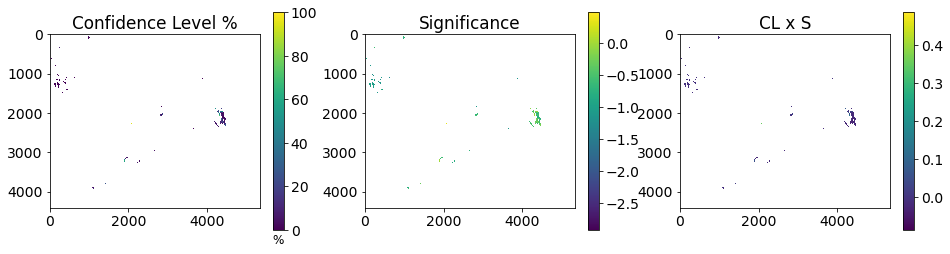

In [55]:
confidence_level = n_change_mag_gt_change_mag_random / n_bootstraps
change_point_significance = 1.- (change_mag_random_sum / n_bootstraps)/change_mag 
#Plot
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
a = ax[0].imshow(confidence_level*100)
cbar0 = fig.colorbar(a, ax=ax[0])
_ = cbar0.ax.set_xlabel('%', fontsize='12')
ax[0].set_title('Confidence Level %')
a = ax[1].imshow(change_point_significance)
_ = fig.colorbar(a, ax=ax[1])
ax[1].set_title('Significance')
a = ax[2].imshow(confidence_level*change_point_significance)
_ = fig.colorbar(a, ax=ax[2])
_ = ax[2].set_title('CL x S')
plt.savefig(f"{output_path}/confidenceLevel_CPSignificance.png", dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the confidence level as a GeoTiff (confidence_level.tiff):</b>
</font>

In [56]:
%%capture
geotiff_from_plot(confidence_level*100, f"{output_path}/confidence_level", coords, utm)

<font face="Calibri" size="3"><b>Save the change point significance as a GeoTiff (cp_significance.tiff):</b>
</font>

In [57]:
%%capture
geotiff_from_plot(change_point_significance, f"{output_path}/cp_significance", coords, utm)

<font face="Calibri" size="3"><b>Save the change point significance as a GeoTiff (cp_significance.tiff):</b>
</font>

In [58]:
%%capture
geotiff_from_plot(confidence_level*change_point_significance, f"{output_path}/confidenceLevel_x_CPSignificance", coords, utm)

<font face="Calibri" size="3">Now we can <b>set a change point threshold</b> to identify most likely change pixels in our map of change candidates:
</font>

In [59]:
change_point_threshold = 0.01

<font face="Calibri" size="3"><b>Plot the detected change pixels based on the change_point_threshold and save it as a png (detected_change_pixels.png):</b></font>

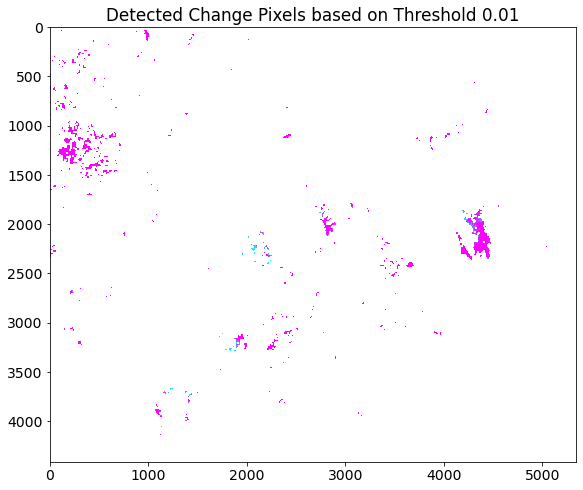

In [60]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
plt.title('Detected Change Pixels based on Threshold %2.2f' % (change_point_threshold))
a = ax.imshow(confidence_level*change_point_significance < change_point_threshold, cmap='cool')
plt.savefig(f"{output_path}/detected_change_pixels.png", dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the detected_change_pixels as a GeoTiff (detected_change_pixels.tiff):</b>
</font>

In [61]:
%%capture
geotiff_from_plot(confidence_level*change_point_significance < change_point_threshold, f"{output_path}/detected_change_pixels", coords, utm, cmap='cool')

<br>
<hr>
<font face="Calibri" size="4"> <b> 4.7 Derive Timing of Change for Each Change Pixel:</b> </font>

<font face="Calibri" size="3">Our last step in the identification of the change points is to extract the timing of the change. We will produce a raster layer that shows the band number of this first date after a change was detected. We will make use of the numpy indexing scheme. First, we create a combined mask of the first threshold and the identified change points after the bootstrapping. For this we use the numpy "mask_or" operation.
</font>

In [62]:
# make a mask of our change points from the new threhold and the previous mask
change_point_mask = np.ma.mask_or(confidence_level*change_point_significance < change_point_threshold, confidence_level.mask)
# Broadcast the mask to the shape of the masked S curves
change_point_mask2 = np.broadcast_to(change_point_mask, summation_masked.shape)
# Make a numpy masked array with this mask
change_point_raster = np.ma.array(summation_masked.data, mask=change_point_mask2)

<font face="Calibri" size="3">To retrieve the dates of the change points we find the band indices in the time series along the time axis where the maximum of the cumulative sums was located. Numpy offers the "argmax" function for this purpose.
</font>

In [63]:
change_point_index = np.ma.argmax(change_point_raster, axis=0)
change_indices = list(np.unique(change_point_index))
print(change_indices)
change_indices.remove(0)
print(change_indices)
# Look up the dates from the indices to get the change dates
all_dates = time_index_subset
change_dates = [str(all_dates[x].date()) for x in change_indices]

[0, 1, 3, 5, 7, 9, 10, 11, 13, 15, 17, 18, 19]
[1, 3, 5, 7, 9, 10, 11, 13, 15, 17, 18, 19]


<font face="Calibri" size="3">Lastly, we <b>plot the change dates by showing the $CP_{index}$ raster and label the change dates. Save the plot as a png (change_dates.png):</b></font>

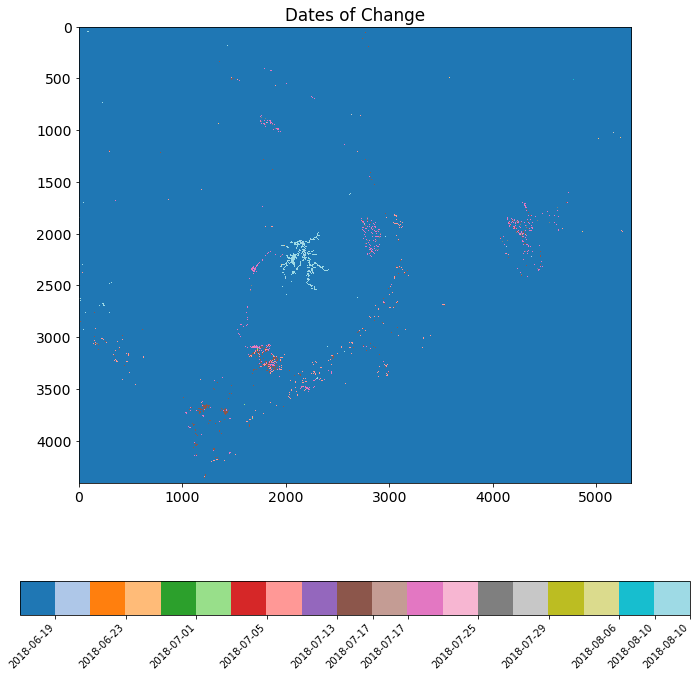

In [64]:
ticks = change_indices
ticklabels = change_dates

cmap = plt.cm.get_cmap('tab20', ticks[-1])
fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.imshow(change_point_index, interpolation='nearest', cmap=cmap)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(p,cax=cbar_ax)

ax.set_title('Dates of Change')
# cbar = fig.colorbar(cax,ticks=ticks)
cbar = fig.colorbar(cax, ticks=ticks, orientation='horizontal')
_ = cbar.ax.set_xticklabels(ticklabels, size=10, rotation=45, ha='right')
plt.savefig(f"{output_path}/change_dates.png", dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the change dates as a GeoTiff (change_dates.tiff):</b>
</font>

In [65]:
%%capture
geotiff_from_plot(change_point_index, f"{output_path}/change_dates", coords, utm, cmap=cmap, interpolation='nearest', dpi=600)

<font face="Calibri" size="2"> <i>GEOS 657 Microwave Remote Sensing - Version 1.2 - October 2020 </i>
    <br>
    <b>Version Changes</b>
    <ul>
        <li>Capture matplotlib deprecation warnings in import cell</li>
        <li>Handle breaking gdal update affecting gdalinfo json output</li> 
    </ul>
</font>